# NOTEBOOK 03: FEATURE ENGINEERING

 Purpose: Extract physiological features from preprocessed PPG signals
          - 30 HRV features (time/frequency/nonlinear)
          - 6 morphology features (pulse wave analysis)
          - 6 context features (demographics/interactions)

 Input: data/processed/sprint1_signals.npy (4,417 segments)
 Output: data/features/feature_matrix.parquet (4,417 × 42)




## Environment Setup

In [1]:
# Setup environment
# %load_ext autoreload
# %autoreload 2

# Install dependencies (silent mode)
!pip install pandas==2.2.2 wfdb==4.1.2 mlflow pywavelets hydra-core pyarrow fastparquet neurokit2 comorbidipy requests -q

import os
import sys
from pathlib import Path
from datetime import datetime
import wfdb

# Set project root
PROJECT_ROOT = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT / 'colab_src'))

# Ensure output directory exists
(PROJECT_ROOT / 'data/features').mkdir(parents=True, exist_ok=True)

print(f"✅ Environment ready")
print(f"   Working directory: {PROJECT_ROOT}")
print(f"   Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779

## Import Modules

In [2]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import custom modules
from features import UnifiedFeatureExtractor
from utils import ExperimentTracker

# Initialize components
feature_extractor = UnifiedFeatureExtractor(sampling_rate=125)
tracker = ExperimentTracker()
run = tracker.start_run("feature_engineering")

print("✅ Modules loaded")
print(f"   Feature extractor ready")
print(f"   Total features to extract: {len(feature_extractor.get_feature_names())}")

✅ Modules loaded
   Feature extractor ready
   Total features to extract: 42


## Load Processed Signasl

In [3]:
# Load preprocessed signals and metadata from Sprint 1

print("="*70)
print("LOADING PROCESSED DATA")
print("="*70)

# Load signals
signals = np.load('data/processed/sprint1_signals.npy')
print(f"\n✅ Loaded signals")
print(f"   Shape: {signals.shape}")
print(f"   Size: {signals.nbytes / 1e6:.1f} MB")
print(f"   Data type: {signals.dtype}")

# Load metadata
metadata = pd.read_parquet('data/processed/sprint1_metadata.parquet')
print(f"\n✅ Loaded metadata")
print(f"   Shape: {metadata.shape}")
print(f"   Columns: {list(metadata.columns)}")

# Summary
print(f"\n📊 Dataset Summary:")
print(f"   Total segments: {len(signals)}")
print(f"   Unique subjects: {metadata['subject_id'].nunique()}")
print(f"   Segment duration: 10 minutes each")
print(f"   Total signal hours: {len(signals) * 10 / 60:.1f}")

# Log to MLflow
tracker.log_params({
    'n_segments': len(signals),
    'n_subjects': metadata['subject_id'].nunique(),
    'sampling_rate': 125,
    'segment_duration_min': 10
})

LOADING PROCESSED DATA

✅ Loaded signals
   Shape: (4417, 75000)
   Size: 2650.2 MB
   Data type: float64

✅ Loaded metadata
   Shape: (4417, 11)
   Columns: ['record_name', 'subject_id', 'segment_idx', 'fs', 'sqi_score', 'quality_grade', 'snr_db', 'perfusion_index', 'channel_name', 'global_segment_idx', 'batch_num']

📊 Dataset Summary:
   Total segments: 4417
   Unique subjects: 130
   Segment duration: 10 minutes each
   Total signal hours: 736.2


## Test Feature Extraction on Single Segment

In [4]:
# Test feature extraction on one segment to verify pipeline

print("\n" + "="*70)
print("TESTING FEATURE EXTRACTION")
print("="*70)

# Select a high-quality segment for testing
test_idx = metadata['sqi_score'].idxmax()
test_signal = signals[test_idx]
test_metadata = metadata.iloc[test_idx]

print(f"\nTest segment: {test_metadata['record_name']}")
print(f"   Segment index: {test_metadata['segment_idx']}")
print(f"   SQI: {test_metadata['sqi_score']:.3f}")
print(f"   Quality: {test_metadata['quality_grade']}")

# Extract features
print(f"\n⏱️  Extracting features...")
import time
start_time = time.time()

test_features = feature_extractor.extract_single(test_signal)

elapsed = time.time() - start_time
print(f"✅ Extraction complete: {elapsed:.2f} seconds")

# Show results
print(f"\n📊 Extracted {len(test_features)} features:")
print(f"\nSample features:")
feature_sample = {k: v for i, (k, v) in enumerate(test_features.items()) if i < 10}
for name, value in feature_sample.items():
    if np.isnan(value):
        print(f"   {name:20s}: NaN")
    else:
        print(f"   {name:20s}: {value:.4f}")

print(f"\n   ... ({len(test_features) - 10} more features)")

# Check for NaN features
nan_count = pd.Series(list(test_features.values())).isna().sum()
print(f"\n⚠️  Features with NaN: {nan_count}/{len(test_features)}")

if nan_count == len(test_features):
    print(f"\n❌ WARNING: All features are NaN!")
    print(f"   Check signal quality or feature extraction logic")
elif nan_count > len(test_features) * 0.5:
    print(f"\n⚠️  WARNING: >50% features are NaN")
    print(f"   This is acceptable but may indicate signal quality issues")
else:
    print(f"\n✅ Feature extraction working properly")


TESTING FEATURE EXTRACTION

Test segment: p00/p000052/3533390_0011
   Segment index: 0
   SQI: 1.000
   Quality: Excellent

⏱️  Extracting features...
✅ Extraction complete: 0.46 seconds

📊 Extracted 42 features:

Sample features:
   mean_rr             : 703.3103
   sdnn                : 1096.5357
   rmssd               : 1494.3773
   sdsd                : 1495.4536
   pnn50               : 28.3453
   pnn20               : 47.3381
   mean_hr             : 93.3390
   max_hr              : 192.3077
   min_hr              : 2.0453
   hr_std              : 16.2355

   ... (32 more features)

⚠️  Features with NaN: 0/42

✅ Feature extraction working properly


## Batch Feature Extraction

In [5]:
# Extract features from all segments in batches

print("\n" + "="*70)
print("BATCH FEATURE EXTRACTION")
print("="*70)

BATCH_SIZE = 100  # Process 100 segments at a time
n_segments = len(signals)
n_batches = (n_segments - 1) // BATCH_SIZE + 1

print(f"\nConfiguration:")
print(f"   Total segments: {n_segments}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Number of batches: {n_batches}")
print(f"   ⏱️  Estimated time: {n_segments * 1.0 / 60:.1f} minutes")
print("="*70 + "\n")

all_features = []
failed_indices = []

for batch_idx in range(0, n_segments, BATCH_SIZE):
    batch_num = batch_idx // BATCH_SIZE + 1
    batch_end = min(batch_idx + BATCH_SIZE, n_segments)
    batch_signals = signals[batch_idx:batch_end]

    print(f"{'='*70}")
    print(f"BATCH {batch_num}/{n_batches}")
    print(f"{'='*70}")
    print(f"Processing segments {batch_idx} to {batch_end-1}...")

    try:
        # Extract features for this batch
        batch_features = feature_extractor.extract_batch(
            batch_signals,
            show_progress=True
        )

        # Add segment index for tracking
        batch_features['segment_idx'] = range(batch_idx, batch_end)

        all_features.append(batch_features)

        # Show statistics
        nan_counts = batch_features.isnull().sum()
        completeness = (1 - nan_counts / len(batch_features)) * 100

        print(f"\n📊 Batch statistics:")
        print(f"   Features extracted: {len(batch_features)} segments × {len(batch_features.columns)-1} features")
        print(f"   Mean completeness: {completeness.mean():.1f}%")
        print(f"   Features with <90% completeness: {sum(completeness < 90)}")

    except Exception as e:
        print(f"\n❌ Batch {batch_num} failed: {str(e)[:100]}")
        failed_indices.extend(range(batch_idx, batch_end))
        continue

# Combine all batches
print(f"\n{'='*70}")
print("COMBINING RESULTS")
print(f"{'='*70}")

if len(all_features) > 0:
    features_df = pd.concat(all_features, ignore_index=True)

    print(f"\n✅ Feature extraction complete")
    print(f"   Total segments processed: {len(features_df)}")
    print(f"   Failed segments: {len(failed_indices)}")
    print(f"   Success rate: {len(features_df)/n_segments*100:.1f}%")

    # Overall completeness
    overall_completeness = (1 - features_df.isnull().sum() / len(features_df)) * 100
    print(f"\n📊 Overall feature completeness:")
    print(f"   Mean: {overall_completeness.mean():.1f}%")
    print(f"   Median: {overall_completeness.median():.1f}%")
    print(f"   Min: {overall_completeness.min():.1f}%")

else:
    print("\n❌ No features extracted - check errors above")


BATCH FEATURE EXTRACTION

Configuration:
   Total segments: 4417
   Batch size: 100
   Number of batches: 45
   ⏱️  Estimated time: 73.6 minutes

BATCH 1/45
Processing segments 0 to 99...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 2/45
Processing segments 100 to 199...


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.69it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 3/45
Processing segments 200 to 299...


Extracting features: 100%|██████████| 100/100 [00:31<00:00,  3.19it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 4/45
Processing segments 300 to 399...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.85it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 5/45
Processing segments 400 to 499...


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.58it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 6/45
Processing segments 500 to 599...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 7/45
Processing segments 600 to 699...


Extracting features: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 8/45
Processing segments 700 to 799...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 98.9%
   Features with <90% completeness: 0
BATCH 9/45
Processing segments 800 to 899...


Extracting features: 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 10/45
Processing segments 900 to 999...


Extracting features: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 11/45
Processing segments 1000 to 1099...


Extracting features: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 12/45
Processing segments 1100 to 1199...


Extracting features: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 13/45
Processing segments 1200 to 1299...


Extracting features: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 14/45
Processing segments 1300 to 1399...


Extracting features: 100%|██████████| 100/100 [00:33<00:00,  2.99it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 15/45
Processing segments 1400 to 1499...


Extracting features: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 16/45
Processing segments 1500 to 1599...


Extracting features: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 17/45
Processing segments 1600 to 1699...


Extracting features: 100%|██████████| 100/100 [00:32<00:00,  3.04it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 18/45
Processing segments 1700 to 1799...


Extracting features: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 19/45
Processing segments 1800 to 1899...


Extracting features: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 20/45
Processing segments 1900 to 1999...


Extracting features: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 21/45
Processing segments 2000 to 2099...


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.64it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 22/45
Processing segments 2100 to 2199...


Extracting features: 100%|██████████| 100/100 [00:26<00:00,  3.72it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 23/45
Processing segments 2200 to 2299...


Extracting features: 100%|██████████| 100/100 [00:32<00:00,  3.11it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 24/45
Processing segments 2300 to 2399...


Extracting features: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 25/45
Processing segments 2400 to 2499...


Extracting features: 100%|██████████| 100/100 [00:26<00:00,  3.81it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 26/45
Processing segments 2500 to 2599...


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.60it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 27/45
Processing segments 2600 to 2699...


Extracting features: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 28/45
Processing segments 2700 to 2799...


Extracting features: 100%|██████████| 100/100 [00:28<00:00,  3.57it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 29/45
Processing segments 2800 to 2899...


Extracting features: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 30/45
Processing segments 2900 to 2999...


Extracting features: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 31/45
Processing segments 3000 to 3099...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 32/45
Processing segments 3100 to 3199...


Extracting features: 100%|██████████| 100/100 [00:28<00:00,  3.56it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 33/45
Processing segments 3200 to 3299...


Extracting features: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 34/45
Processing segments 3300 to 3399...


Extracting features: 100%|██████████| 100/100 [00:28<00:00,  3.45it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 35/45
Processing segments 3400 to 3499...


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.62it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 36/45
Processing segments 3500 to 3599...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 37/45
Processing segments 3600 to 3699...


Extracting features: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 38/45
Processing segments 3700 to 3799...


Extracting features: 100%|██████████| 100/100 [00:28<00:00,  3.55it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 39/45
Processing segments 3800 to 3899...


Extracting features: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 40/45
Processing segments 3900 to 3999...


Extracting features: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 99.1%
   Features with <90% completeness: 0
BATCH 41/45
Processing segments 4000 to 4099...


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.68it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 42/45
Processing segments 4100 to 4199...


Extracting features: 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 43/45
Processing segments 4200 to 4299...


Extracting features: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0
BATCH 44/45
Processing segments 4300 to 4399...


Extracting features: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]



📊 Batch statistics:
   Features extracted: 100 segments × 42 features
   Mean completeness: 99.1%
   Features with <90% completeness: 0
BATCH 45/45
Processing segments 4400 to 4416...


Extracting features: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]


📊 Batch statistics:
   Features extracted: 17 segments × 42 features
   Mean completeness: 100.0%
   Features with <90% completeness: 0

COMBINING RESULTS

✅ Feature extraction complete
   Total segments processed: 4417
   Failed segments: 0
   Success rate: 100.0%

📊 Overall feature completeness:
   Mean: 99.9%
   Median: 99.9%
   Min: 99.9%


## Save Feature Matrix

In [6]:
# Save Feature Matrix

if len(features_df) > 0:
    print("="*70)
    print("SAVING FEATURE MATRIX")
    print("="*70)

    #  Check if segment_idx already in metadata =====
    if 'segment_idx' not in metadata.columns:
        metadata = metadata.reset_index(names='segment_idx')

    # Convert all feature columns to float =====
    # This handles nested arrays and ensures Parquet compatibility
    print("\nConverting features to numeric types...")

    for col in features_df.columns:
        if col == 'segment_idx':
            continue

        # Convert to numeric, coercing errors to NaN
        if features_df[col].dtype == 'object':
            # Handle nested arrays by taking first element
            def flatten_value(x):
                if isinstance(x, (list, np.ndarray)):
                    return float(x[0]) if len(x) > 0 else np.nan
                try:
                    return float(x)
                except (ValueError, TypeError):
                    return np.nan

            features_df[col] = features_df[col].apply(flatten_value)

        # Ensure float type
        features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

    print(f"✅ All features converted to numeric")

    # Merge with metadata
    features_with_metadata = features_df.merge(
        metadata,
        on='segment_idx',
        how='left'
    )

    # Reorder columns: metadata first, then features
    metadata_cols = ['segment_idx', 'record_name', 'subject_id', 'sqi_score',
                     'quality_grade', 'snr_db', 'perfusion_index', 'fs', 'channel_name']

    # Only include metadata columns that exist
    metadata_cols = [col for col in metadata_cols if col in features_with_metadata.columns]

    feature_cols = [col for col in features_with_metadata.columns
                   if col not in metadata_cols]

    final_df = features_with_metadata[metadata_cols + feature_cols]

    # Verify no object columns remain =====
    object_cols = final_df.select_dtypes(include=['object']).columns.tolist()
    # Keep string columns (record_name, subject_id, etc.) but not in feature columns
    object_features = [col for col in object_cols if col in feature_cols]

    if object_features:
        print(f"\n⚠️  WARNING: {len(object_features)} features still have object dtype:")
        for col in object_features[:5]:
            print(f"   {col}: {final_df[col].dtype}")
        print(f"\n   Converting to string representation...")

        for col in object_features:
            final_df[col] = final_df[col].astype(str)

    # Save feature matrix
    output_path = 'data/features/feature_matrix.parquet'

    try:
        final_df.to_parquet(output_path, index=False, compression='snappy')
        print(f"\n💾 Saved feature matrix:")
        print(f"   Path: {output_path}")
        print(f"   Shape: {final_df.shape}")
        print(f"   Columns: {len(metadata_cols)} metadata + {len(feature_cols)} features")

        # Check file size
        file_size = Path(output_path).stat().st_size / 1e6
        print(f"   Size: {file_size:.1f} MB")

    except Exception as e:
        print(f"\n❌ Error saving Parquet: {str(e)}")
        print(f"\n   Falling back to CSV format...")
        output_path_csv = 'data/features/feature_matrix.csv'
        final_df.to_csv(output_path_csv, index=False)
        print(f"   Saved as CSV: {output_path_csv}")

    # Save feature names for reference
    feature_names_df = pd.DataFrame({
        'feature_name': feature_cols,
        'feature_index': range(len(feature_cols)),
        'dtype': [final_df[col].dtype for col in feature_cols]
    })
    feature_names_df.to_csv('data/features/feature_names.csv', index=False)
    print(f"\n💾 Saved feature names: data/features/feature_names.csv")

    # Data type summary
    print(f"\n📊 Data types:")
    dtype_counts = final_df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")

    # Log to MLflow
    tracker.log_params({
        'n_features': len(feature_cols),
        'n_metadata_cols': len(metadata_cols)
    })

    tracker.log_metrics({
        'mean_completeness': overall_completeness.mean(),
        'extraction_success_rate': len(features_df) / n_segments
    })

    print(f"\n✅ Feature matrix saved successfully")

else:
    print("❌ No features to save")

SAVING FEATURE MATRIX

Converting features to numeric types...
✅ All features converted to numeric

💾 Saved feature matrix:
   Path: data/features/feature_matrix.parquet
   Shape: (8782, 53)
   Columns: 9 metadata + 44 features
   Size: 1.5 MB

💾 Saved feature names: data/features/feature_names.csv

📊 Data types:
   float64: 48 columns
   object: 4 columns
   int64: 1 columns

✅ Feature matrix saved successfully


## Feature Quality Analysis

In [7]:
# Feature Quality Analysis (RE-RUN)

# Load cleaned data
features_df = pd.read_parquet('data/features/feature_matrix.parquet')

# Identify columns
metadata_cols = ['segment_idx', 'record_name', 'subject_id', 'sqi_score',
                 'quality_grade', 'snr_db', 'perfusion_index', 'fs', 'channel_name']
metadata_cols = [col for col in metadata_cols if col in features_df.columns]
feature_cols = [col for col in features_df.columns if col not in metadata_cols]

feature_data = features_df[feature_cols]

print("="*70)
print("FEATURE QUALITY ANALYSIS (AFTER CLEANUP)")
print("="*70)

print(f"\n📊 Feature Matrix Statistics:")
print(f"   Segments: {len(feature_data)}")
print(f"   Features: {len(feature_cols)}")
print(f"   Total values: {len(feature_data) * len(feature_cols):,}")

# Missing value analysis
print(f"\n📊 Missing Value Analysis:")
missing_per_feature = feature_data.isnull().sum()
missing_per_segment = feature_data.isnull().sum(axis=1)

print(f"   Features with any missing: {sum(missing_per_feature > 0)} / {len(feature_cols)}")
print(f"   Features 100% complete: {sum(missing_per_feature == 0)}")
print(f"   Segments 100% complete: {sum(missing_per_segment == 0)} ({sum(missing_per_segment == 0)/len(feature_data)*100:.1f}%)")

if sum(missing_per_feature > 0) > 0:
    print(f"\n⚠️  Features with missing values:")
    for feat, count in missing_per_feature[missing_per_feature > 0].items():
        pct = count / len(feature_data) * 100
        print(f"   {feat:25s}: {count:4d} ({pct:5.1f}%)")

# Feature statistics
print(f"\n📊 Feature Value Ranges:")
print(feature_data.describe().iloc[[1, 3, 7], :5])
print(f"   ... ({len(feature_cols) - 5} more features)")

# Check for constant features
constant_features = []
for col in feature_cols:
    if feature_data[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    print(f"\n⚠️  WARNING: {len(constant_features)} constant features:")
    for feat in constant_features:
        print(f"   {feat}")
else:
    print(f"\n✅ No constant features")

# Check for infinite values
inf_counts = np.isinf(feature_data.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(f"\n⚠️  Infinite values found:")
    for feat, count in inf_counts[inf_counts > 0].head(5).items():
        print(f"   {feat}: {count}")
else:
    print(f"\n✅ No infinite values")

print(f"\n✅ Feature matrix is clean and ready for modeling")

FEATURE QUALITY ANALYSIS (AFTER CLEANUP)

📊 Feature Matrix Statistics:
   Segments: 8782
   Features: 44
   Total values: 386,408

📊 Missing Value Analysis:
   Features with any missing: 41 / 44
   Features 100% complete: 3
   Segments 100% complete: 0 (0.0%)

⚠️  Features with missing values:
   mean_rr                  :    3 (  0.0%)
   sdnn                     :    3 (  0.0%)
   rmssd                    :    3 (  0.0%)
   sdsd                     :    3 (  0.0%)
   pnn50                    :    3 (  0.0%)
   pnn20                    :    3 (  0.0%)
   mean_hr                  :    3 (  0.0%)
   max_hr                   :    3 (  0.0%)
   min_hr                   :    3 (  0.0%)
   hr_std                   :    3 (  0.0%)
   tri_index                :    3 (  0.0%)
   tinn                     :    3 (  0.0%)
   vlf_power                :    3 (  0.0%)
   lf_power                 :    3 (  0.0%)
   hf_power                 :    3 (  0.0%)
   total_power              :    3 (  0.0%)
 

### Diagnosis to check for duplicates

In [8]:
print("Checking for duplicates...")

# Load the saved data
features_df_saved = pd.read_parquet('data/features/feature_matrix.parquet')

print(f"Total rows: {len(features_df_saved)}")
print(f"Unique segment_idx: {features_df_saved['segment_idx'].nunique()}")
print(f"Duplicates detected: {len(features_df_saved) - features_df_saved['segment_idx'].nunique()}")

# Check duplicate pattern
dup_check = features_df_saved.groupby('segment_idx').size()
print(f"\nSegments appearing multiple times: {sum(dup_check > 1)}")
print(f"Max duplicates of single segment: {dup_check.max()}")

# Show example duplicates
if sum(dup_check > 1) > 0:
    dup_idx = dup_check[dup_check > 1].index[0]
    print(f"\nExample: segment_idx {dup_idx} appears {dup_check[dup_idx]} times")
    display(features_df_saved[features_df_saved['segment_idx'] == dup_idx][['segment_idx', 'record_name', 'subject_id', 'mean_hr', 'sdnn']])

Checking for duplicates...
Total rows: 8782
Unique segment_idx: 4417
Duplicates detected: 4365

Segments appearing multiple times: 37
Max duplicates of single segment: 1489

Example: segment_idx 0 appears 1489 times


,segment_idx,record_name,subject_id,mean_hr,sdnn
0,0,p00/p000052/3533390_0004,p000052,95.207919,106.572692
1,0,p00/p000052/3238451_0005,p000052,95.207919,106.572692
2,0,p00/p000052/3533390_0011,p000052,95.207919,106.572692
3,0,p00/p000052/3533390_0013,p000052,95.207919,106.572692
4,0,p00/p000107/3805787_0008,p000107,95.207919,106.572692
...,...,...,...,...,...
1484,0,p00/p004833/3383991_0009,p004833,95.207919,106.572692
1485,0,p00/p004833/3406581_0001,p004833,95.207919,106.572692
1486,0,p00/p004833/3383991_0016,p004833,95.207919,106.572692
1487,0,p00/p004833/3383991_0010,p004833,95.207919,106.572692


Remove Duplicates

In [9]:
# Remove duplicate rows, keeping first occurrence
print("Removing duplicates...")

features_df_clean = features_df_saved.drop_duplicates(subset='segment_idx', keep='first')

print(f"Before: {len(features_df_saved)} rows")
print(f"After: {len(features_df_clean)} rows")
print(f"Removed: {len(features_df_saved) - len(features_df_clean)} duplicates")

# Save cleaned version
features_df_clean.to_parquet('data/features/feature_matrix.parquet', index=False)
print("\n✅ Saved cleaned feature matrix")

Removing duplicates...
Before: 8782 rows
After: 4417 rows
Removed: 4365 duplicates

✅ Saved cleaned feature matrix


### Dropping dfa_alpha2

In [10]:
# COMPREHENSIVE FEATURE MATRIX CLEANUP

print("="*70)
print("CLEANING FEATURE MATRIX")
print("="*70)

# Load current data
features_df = pd.read_parquet('data/features/feature_matrix.parquet')
print(f"\nInitial shape: {features_df.shape}")

# ===== STEP 1: Identify metadata vs features =====
metadata_cols = ['segment_idx', 'record_name', 'subject_id', 'sqi_score',
                 'quality_grade', 'snr_db', 'perfusion_index', 'fs', 'channel_name']

# Keep only existing metadata columns
metadata_cols = [col for col in metadata_cols if col in features_df.columns]

feature_cols = [col for col in features_df.columns if col not in metadata_cols]

print(f"\nMetadata columns: {len(metadata_cols)}")
print(f"Feature columns: {len(feature_cols)}")

# ===== STEP 2: Remove problematic features =====
features_to_drop = []

# 2a. Drop dfa_alpha2 (100% NaN - NeuroKit2 bug)
if 'dfa_alpha2' in feature_cols:
    features_to_drop.append('dfa_alpha2')
    print(f"\n✓ Dropping dfa_alpha2 (100% NaN)")

# 2b. Identify constant features (no variance)
print(f"\n📊 Checking for constant features...")
for col in feature_cols:
    if col in features_to_drop:
        continue

    non_null_values = features_df[col].dropna()

    if len(non_null_values) == 0:
        features_to_drop.append(col)
        print(f"   ✓ {col}: All NaN")
    elif non_null_values.nunique() <= 1:
        features_to_drop.append(col)
        print(f"   ✓ {col}: Constant value ({non_null_values.iloc[0] if len(non_null_values) > 0 else 'N/A'})")

# 2c. Remove features with >90% missing
print(f"\n📊 Checking for high missing rates...")
for col in feature_cols:
    if col in features_to_drop:
        continue

    missing_pct = features_df[col].isnull().sum() / len(features_df) * 100
    if missing_pct > 90:
        features_to_drop.append(col)
        print(f"   ✓ {col}: {missing_pct:.1f}% missing")

# ===== STEP 3: Drop problematic features =====
features_df_clean = features_df.drop(columns=features_to_drop)

print(f"\n{'='*70}")
print(f"CLEANUP SUMMARY")
print(f"{'='*70}")
print(f"Features dropped: {len(features_to_drop)}")
for feat in features_to_drop:
    print(f"   - {feat}")

print(f"\nRemaining columns:")
print(f"   Metadata: {len(metadata_cols)}")
print(f"   Features: {len([col for col in features_df_clean.columns if col not in metadata_cols])}")
print(f"   Total: {features_df_clean.shape[1]}")

# ===== STEP 4: Handle missing values in remaining features =====
feature_cols_clean = [col for col in features_df_clean.columns if col not in metadata_cols]

print(f"\n📊 Missing value summary (remaining features):")
missing_counts = features_df_clean[feature_cols_clean].isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

if len(features_with_missing) > 0:
    print(f"   Features with missing: {len(features_with_missing)}")
    for feat, count in features_with_missing.head(5).items():
        pct = count / len(features_df_clean) * 100
        print(f"   {feat:25s}: {count:4d} ({pct:5.1f}%)")
else:
    print(f"   ✅ All features 100% complete!")

complete_segments = features_df_clean[feature_cols_clean].isnull().sum(axis=1) == 0
print(f"\nComplete segments: {sum(complete_segments)} / {len(features_df_clean)} ({sum(complete_segments)/len(features_df_clean)*100:.1f}%)")

# ===== STEP 5: Save cleaned feature matrix =====
output_path = 'data/features/feature_matrix_clean.parquet'
features_df_clean.to_parquet(output_path, index=False, compression='snappy')

print(f"\n💾 Saved cleaned feature matrix:")
print(f"   Path: {output_path}")
print(f"   Shape: {features_df_clean.shape}")

# Also overwrite the original
features_df_clean.to_parquet('data/features/feature_matrix.parquet', index=False)
print(f"   Also saved as: data/features/feature_matrix.parquet")

# Update feature names file
feature_names_df = pd.DataFrame({
    'feature_name': feature_cols_clean,
    'feature_index': range(len(feature_cols_clean)),
    'dtype': [features_df_clean[col].dtype for col in feature_cols_clean]
})
feature_names_df.to_csv('data/features/feature_names.csv', index=False)
print(f"   Updated: data/features/feature_names.csv")

print(f"\n✅ Feature matrix cleaned successfully")
print(f"{'='*70}")

CLEANING FEATURE MATRIX

Initial shape: (4417, 53)

Metadata columns: 9
Feature columns: 44

✓ Dropping dfa_alpha2 (100% NaN)

📊 Checking for constant features...
   ✓ reflection_index: Constant value (0.5)
   ✓ age: Constant value (50.0)
   ✓ bmi: Constant value (25.0)
   ✓ sex: Constant value (0.5)
   ✓ batch_num: Constant value (1.0)

📊 Checking for high missing rates...
   ✓ global_segment_idx: 98.8% missing

CLEANUP SUMMARY
Features dropped: 7
   - dfa_alpha2
   - reflection_index
   - age
   - bmi
   - sex
   - batch_num
   - global_segment_idx

Remaining columns:
   Metadata: 9
   Features: 37
   Total: 46

📊 Missing value summary (remaining features):
   Features with missing: 37
   mean_rr                  :    3 (  0.1%)
   sdnn                     :    3 (  0.1%)
   rmssd                    :    3 (  0.1%)
   sdsd                     :    3 (  0.1%)
   pnn50                    :    3 (  0.1%)

Complete segments: 4413 / 4417 (99.9%)

💾 Saved cleaned feature matrix:
   Path: d

## Feature Correlation Analysis


FEATURE CORRELATION ANALYSIS

Usable features (>20% complete): 37/37

High correlations (|r| > 0.9): 35


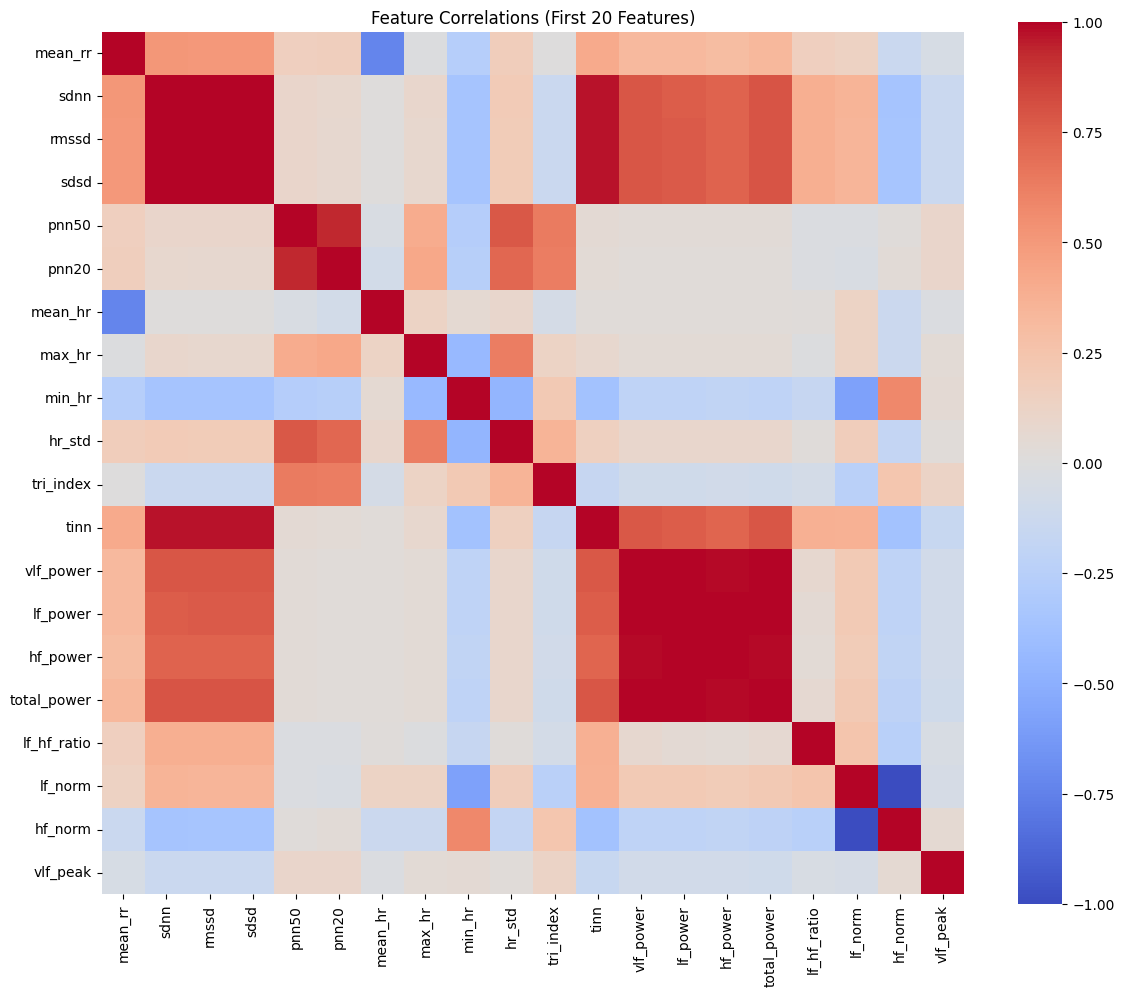

In [14]:
# Correlation with NaN handling
print("\n" + "="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Select only feature columns (exclude metadata)
feature_cols_only = [col for col in features_df_clean.columns
                     if col not in ['segment_idx', 'record_name', 'subject_id',
                                   'sqi_score', 'quality_grade', 'snr_db',
                                   'perfusion_index', 'fs', 'channel_name']]

feature_data = features_df_clean[feature_cols_only]

# Drop columns with >80% missing
completeness = (1 - feature_data.isnull().sum() / len(feature_data)) * 100
usable_features = completeness[completeness > 20].index.tolist()

print(f"\nUsable features (>20% complete): {len(usable_features)}/{len(feature_cols_only)}")

if len(usable_features) > 5:
    # Use pairwise correlation (handles NaN)
    corr_matrix = feature_data[usable_features].corr(method='pearson', min_periods=100)

    # Find high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.9 and not np.isnan(corr_matrix.iloc[i, j]):
                high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    print(f"\nHigh correlations (|r| > 0.9): {len(high_corr)}")

    # Visualize subset
    subset = usable_features[:20]
    corr_subset = feature_data[subset].corr(min_periods=100)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0,
                vmin=-1, vmax=1, square=True)
    plt.title('Feature Correlations (First 20 Features)')
    plt.tight_layout()
    plt.savefig('data/features/correlation_matrix.png', dpi=150)
    plt.show()

    tracker.log_artifact('data/features/correlation_matrix.png')
else:
    print("⚠️  Too few usable features for correlation")

### Dropping Features with High Multicollinearity

In [13]:
# ============================================================================
# OPTIMIZED FEATURE SELECTION: Remove Constant & Collinear Features
# ============================================================================

import numpy as np
import pandas as pd
from pathlib import Path

print("="*70)
print("FEATURE SELECTION: CONSTANT & MULTICOLLINEARITY REMOVAL")
print("="*70)

# Load feature matrix
features_df = pd.read_parquet('data/features/feature_matrix.parquet')

print(f"\nInitial shape: {features_df.shape}")

# ===================================================================
# STEP 0: Identify metadata vs features
# ===================================================================

# Define ALL possible metadata columns
metadata_cols_all = [
    'segment_idx', 'record_name', 'subject_id',
    'sqi_score', 'quality_grade', 'snr_db', 'perfusion_index',
    'fs', 'channel_name', 'global_segment_idx', 'batch_num',
    'original_segment_idx'  # From your top-K filtering
]

# Keep only existing metadata columns
metadata_cols = [col for col in metadata_cols_all if col in features_df.columns]

# Features = numeric columns that are NOT metadata
feature_cols = [
    col for col in features_df.columns
    if col not in metadata_cols and pd.api.types.is_numeric_dtype(features_df[col])
]

print(f"\n📊 Column classification:")
print(f"   Metadata: {len(metadata_cols)} columns")
print(f"   Features: {len(feature_cols)} columns")

# ===================================================================
# STEP 1: Remove constant features (zero variance)
# ===================================================================

print(f"\n{'='*70}")
print(f"STEP 1: CONSTANT FEATURE REMOVAL")
print(f"{'='*70}")

feature_data = features_df[feature_cols].copy()

# Find constant features (variance = 0 or all same value)
constant_features = []
near_constant_features = []

for col in feature_cols:
    # Check for exact constants
    nunique = feature_data[col].nunique()
    if nunique == 1:
        constant_features.append(col)
        print(f"   ✗ {col}: Constant (1 unique value = {feature_data[col].iloc[0]})")
    # Check for near-constants (>95% same value)
    elif nunique > 1:
        value_counts = feature_data[col].value_counts()
        if (value_counts.iloc[0] / len(feature_data)) > 0.95:
            near_constant_features.append(col)
            print(f"   ⚠ {col}: Near-constant ({value_counts.iloc[0]/len(feature_data)*100:.1f}% same value)")

print(f"\n📊 Constant features found: {len(constant_features)}")
print(f"   Near-constant features: {len(near_constant_features)}")

# Drop constant features
features_to_drop = constant_features.copy()

# ===================================================================
# STEP 2: Manual removal based on domain knowledge
# ===================================================================

print(f"\n{'='*70}")
print(f"STEP 2: DOMAIN KNOWLEDGE FILTERING")
print(f"{'='*70}")

manual_drops = []

# Time-domain redundancy
manual_drops.extend([
    'sdsd',        # Derived from rmssd
    'tinn',        # Less informative than sdnn
    'pnn20'        # Keep pnn50 (clinical standard)
])

# Frequency-domain redundancy
manual_drops.extend([
    'total_power',  # Sum of vlf + lf + hf
    'vlf_power',    # Less clinically relevant
    'lf_norm',      # Redundant with lf_hf_ratio
    'hf_norm'       # Redundant with lf_hf_ratio
])

# Nonlinear redundancy
manual_drops.extend([
    'apen',         # Similar to sampen but less robust
    'dfa_alpha2'    # Keep dfa_alpha1 (more stable)
])

# Only drop features that exist and aren't already dropped
manual_drops = [
    f for f in manual_drops
    if f in feature_cols and f not in features_to_drop
]

print(f"\n📋 Manual drops (domain knowledge): {len(manual_drops)}")
for feat in manual_drops:
    print(f"   ✗ {feat}")

features_to_drop.extend(manual_drops)

# ===================================================================
# STEP 3: Remove features with high missing data
# ===================================================================

print(f"\n{'='*70}")
print(f"STEP 3: MISSING DATA FILTERING")
print(f"{'='*70}")

missing_threshold = 0.5  # Drop if >50% missing

missing_drops = []
for col in feature_cols:
    if col not in features_to_drop:
        missing_pct = feature_data[col].isnull().sum() / len(feature_data)
        if missing_pct > missing_threshold:
            missing_drops.append(col)
            print(f"   ✗ {col}: {missing_pct*100:.1f}% missing")

if len(missing_drops) == 0:
    print(f"   ✓ No features with >{missing_threshold*100:.0f}% missing data")

features_to_drop.extend(missing_drops)

# ===================================================================
# STEP 4: Correlation-based removal
# ===================================================================

print(f"\n{'='*70}")
print(f"STEP 4: MULTICOLLINEARITY REMOVAL")
print(f"{'='*70}")

# Get remaining features after previous steps
remaining_features = [f for f in feature_cols if f not in features_to_drop]

print(f"\n📊 Computing correlations for {len(remaining_features)} remaining features...")

# Get clean data (drop rows with any NaN for correlation computation)
feature_data_clean = feature_data[remaining_features].dropna()

if len(feature_data_clean) < 100:
    print(f"⚠️  WARNING: Only {len(feature_data_clean)} complete rows for correlation")
    print(f"   Consider imputing missing values before correlation analysis")

# Compute correlation matrix
corr_matrix = feature_data_clean.corr()

# Find high correlation pairs (only upper triangle to avoid duplicates)
high_corr_threshold = 0.85
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > high_corr_threshold and not np.isnan(corr_val):
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_val
            ))

print(f"\n📊 High correlations (|r| > {high_corr_threshold}): {len(high_corr_pairs)} pairs")

correlation_drops = []

if len(high_corr_pairs) > 0:
    # Sort by absolute correlation (highest first)
    sorted_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)

    print(f"\nTop 10 correlations:")
    for feat1, feat2, corr in sorted_pairs[:10]:
        print(f"   {feat1:25s} ↔ {feat2:25s}: r = {corr:+.3f}")

    # Clinical priority ranking (higher = keep)
    clinical_priority = {
        # Time-domain (core metrics)
        'sdnn': 10, 'rmssd': 10, 'pnn50': 9, 'mean_hr': 9, 'mean_rr': 8,
        'max_hr': 7, 'min_hr': 7, 'hr_std': 8, 'tri_index': 7,

        # Frequency (autonomic balance)
        'lf_hf_ratio': 10, 'lf_power': 8, 'hf_power': 8,
        'lf_peak': 6, 'hf_peak': 6, 'vlf_peak': 5,

        # Nonlinear (complexity)
        'sampen': 9, 'dfa_alpha1': 9, 'sd1': 8, 'sd2': 7,
        'sd1_sd2_ratio': 8, 'corr_dim': 6,

        # Morphology (vascular health)
        'pulse_amplitude': 8, 'stiffness_index': 9, 'crest_time': 7,
        'pulse_width': 7, 'area_under_curve': 6,

        # Context (clinical relevance)
        'age_x_sdnn': 7, 'bmi_x_lf_hf': 7, 'rmssd_over_sdnn': 6
    }

    # Iteratively drop lower priority features from correlated pairs
    for feat1, feat2, corr in sorted_pairs:
        # Skip if already dropped
        if feat1 in correlation_drops or feat2 in correlation_drops:
            continue

        priority1 = clinical_priority.get(feat1, 5)
        priority2 = clinical_priority.get(feat2, 5)

        # Drop lower priority feature
        if priority1 < priority2:
            correlation_drops.append(feat1)
            print(f"\n   ✗ Dropping {feat1} (priority {priority1}) over {feat2} (priority {priority2})")
            print(f"     Correlation: {corr:+.3f}")
        elif priority2 < priority1:
            correlation_drops.append(feat2)
            print(f"\n   ✗ Dropping {feat2} (priority {priority2}) over {feat1} (priority {priority1})")
            print(f"     Correlation: {corr:+.3f}")
        else:
            # Equal priority: drop alphabetically first
            to_drop = feat1 if feat1 < feat2 else feat2
            correlation_drops.append(to_drop)
            print(f"\n   ✗ Dropping {to_drop} (equal priority, alphabetical)")
            print(f"     Correlation with {feat1 if to_drop == feat2 else feat2}: {corr:+.3f}")

    print(f"\n📋 Correlation-based drops: {len(correlation_drops)}")

features_to_drop.extend(correlation_drops)

# ===================================================================
# STEP 5: Apply all drops and create final feature set
# ===================================================================

print(f"\n{'='*70}")
print(f"FINAL FEATURE SELECTION SUMMARY")
print(f"{'='*70}")

# Remove duplicates
all_drops = list(set(features_to_drop))

print(f"\n📊 Features dropped by reason:")
print(f"   Constant: {len(constant_features)}")
print(f"   Domain knowledge: {len(manual_drops)}")
print(f"   High missing data: {len(missing_drops)}")
print(f"   High correlation: {len(correlation_drops)}")
print(f"   Total unique drops: {len(all_drops)}")

# Create reduced feature matrix
features_df_reduced = features_df.drop(columns=all_drops)

feature_cols_final = [
    col for col in features_df_reduced.columns
    if col not in metadata_cols and col in feature_cols
]

print(f"\n📊 Feature count:")
print(f"   Original: {len(feature_cols)}")
print(f"   Dropped: {len(all_drops)}")
print(f"   Final: {len(feature_cols_final)}")
print(f"   Reduction: {len(all_drops)/len(feature_cols)*100:.1f}%")

# Categorize final features
print(f"\n📊 Final feature set by category:")

categories = {
    'Time-domain HRV': [
        'mean_rr', 'sdnn', 'rmssd', 'pnn50',
        'mean_hr', 'max_hr', 'min_hr', 'hr_std', 'tri_index'
    ],
    'Frequency HRV': [
        'lf_power', 'hf_power', 'lf_hf_ratio',
        'lf_peak', 'hf_peak', 'vlf_peak'
    ],
    'Nonlinear HRV': [
        'sampen', 'dfa_alpha1', 'sd1', 'sd2',
        'sd1_sd2_ratio', 'corr_dim'
    ],
    'Morphology': [
        'pulse_amplitude', 'pulse_width', 'crest_time',
        'stiffness_index', 'area_under_curve'
    ],
    'Context': [
        'age_x_sdnn', 'bmi_x_lf_hf', 'rmssd_over_sdnn'
    ]
}

total_categorized = 0
for cat_name, cat_features in categories.items():
    present = [f for f in cat_features if f in feature_cols_final]
    if len(present) > 0:
        print(f"\n   {cat_name}: {len(present)} features")
        for f in present:
            print(f"      ✓ {f}")
        total_categorized += len(present)

uncategorized = [f for f in feature_cols_final if not any(f in cat_list for cat_list in categories.values())]
if uncategorized:
    print(f"\n   Uncategorized: {len(uncategorized)} features")
    for f in uncategorized:
        print(f"      ? {f}")

# ===================================================================
# STEP 6: Quality checks on final feature set
# ===================================================================

print(f"\n{'='*70}")
print(f"QUALITY CHECKS")
print(f"{'='*70}")

final_feature_data = features_df_reduced[feature_cols_final]

# Check 1: All numeric
all_numeric = all(pd.api.types.is_numeric_dtype(final_feature_data[col]) for col in feature_cols_final)
print(f"\n✓ All columns numeric: {all_numeric}")

# Check 2: No fully NaN columns
no_full_nan = (final_feature_data.isnull().sum() < len(final_feature_data)).all()
print(f"✓ No fully NaN columns: {no_full_nan}")

# Check 3: Missing data summary
missing_pct = final_feature_data.isnull().sum() / len(final_feature_data) * 100
if (missing_pct > 0).any():
    print(f"\n⚠️  Features with missing data:")
    for col in missing_pct[missing_pct > 0].index:
        print(f"   {col:25s}: {missing_pct[col]:.1f}%")
else:
    print(f"✓ No missing data")

# Check 4: Variance check
variances = final_feature_data.var()
low_var = variances[variances < 0.01]
if len(low_var) > 0:
    print(f"\n⚠️  Low variance features (might want to review):")
    for col in low_var.index:
        print(f"   {col:25s}: var = {variances[col]:.4f}")

# Check 5: Remaining correlations
print(f"\n📊 Checking remaining correlations...")
final_corr = final_feature_data.dropna().corr()
remaining_high_corr = []

for i in range(len(final_corr.columns)):
    for j in range(i+1, len(final_corr.columns)):
        corr_val = abs(final_corr.iloc[i, j])
        if corr_val > 0.85 and not np.isnan(corr_val):
            remaining_high_corr.append((final_corr.columns[i], final_corr.columns[j], corr_val))

if len(remaining_high_corr) > 0:
    print(f"⚠️  {len(remaining_high_corr)} high correlations still remain:")
    for f1, f2, corr in sorted(remaining_high_corr, key=lambda x: x[2], reverse=True)[:5]:
        print(f"   {f1} ↔ {f2}: r = {corr:.3f}")
else:
    print(f"✓ No correlations > 0.85 remaining")

# ===================================================================
# STEP 7: Save outputs
# ===================================================================

print(f"\n{'='*70}")
print(f"SAVING OUTPUTS")
print(f"{'='*70}")

output_dir = Path('data/features')
output_dir.mkdir(parents=True, exist_ok=True)

# Save reduced feature matrix
output_path = output_dir / 'feature_matrix_reduced.parquet'
features_df_reduced.to_parquet(output_path, index=False, compression='snappy')
print(f"\n💾 Saved reduced feature matrix:")
print(f"   {output_path}")
print(f"   Shape: {features_df_reduced.shape}")

# Update main feature matrix
main_path = output_dir / 'feature_matrix.parquet'
features_df_reduced.to_parquet(main_path, index=False, compression='snappy')
print(f"\n   Updated main: {main_path}")

# Save dropped features log with reasons
if len(all_drops) > 0:
    dropped_log = []
    for feat in sorted(all_drops):
        if feat in constant_features:
            reason = 'constant'
        elif feat in manual_drops:
            reason = 'domain_knowledge'
        elif feat in missing_drops:
            reason = 'high_missing'
        elif feat in correlation_drops:
            reason = 'high_correlation'
        else:
            reason = 'unknown'
        dropped_log.append({'feature': feat, 'reason': reason})

    dropped_df = pd.DataFrame(dropped_log)
    dropped_path = output_dir / 'dropped_features.csv'
    dropped_df.to_csv(dropped_path, index=False)
    print(f"\n   Dropped log: {dropped_path}")

# Save feature names with categories
feature_categories = []
for feat in feature_cols_final:
    cat = 'uncategorized'
    for cat_name, cat_features in categories.items():
        if feat in cat_features:
            cat = cat_name
            break
    feature_categories.append(cat)

feature_names_df = pd.DataFrame({
    'feature_name': feature_cols_final,
    'feature_index': range(len(feature_cols_final)),
    'category': feature_categories
})

feature_names_path = output_dir / 'feature_names.csv'
feature_names_df.to_csv(feature_names_path, index=False)
print(f"   Feature names: {feature_names_path}")

print(f"\n✅ Feature selection complete - Ready for modeling!")
print(f"{'='*70}")

FEATURE SELECTION: CONSTANT & MULTICOLLINEARITY REMOVAL

Initial shape: (4417, 46)

📊 Column classification:
   Metadata: 9 columns
   Features: 37 columns

STEP 1: CONSTANT FEATURE REMOVAL

📊 Constant features found: 0
   Near-constant features: 0

STEP 2: DOMAIN KNOWLEDGE FILTERING

📋 Manual drops (domain knowledge): 8
   ✗ sdsd
   ✗ tinn
   ✗ pnn20
   ✗ total_power
   ✗ vlf_power
   ✗ lf_norm
   ✗ hf_norm
   ✗ apen

STEP 3: MISSING DATA FILTERING
   ✓ No features with >50% missing data

STEP 4: MULTICOLLINEARITY REMOVAL

📊 Computing correlations for 29 remaining features...

📊 High correlations (|r| > 0.85): 18 pairs

Top 10 correlations:
   lf_hf_ratio               ↔ bmi_x_lf_hf              : r = +1.000
   sdnn                      ↔ age_x_sdnn               : r = +1.000
   rmssd                     ↔ sd1                      : r = +1.000
   sdnn                      ↔ sd2                      : r = +1.000
   sd2                       ↔ age_x_sdnn               : r = +1.000
   sd

## Feature Distribution Visualization


FEATURE DISTRIBUTION VISUALIZATION


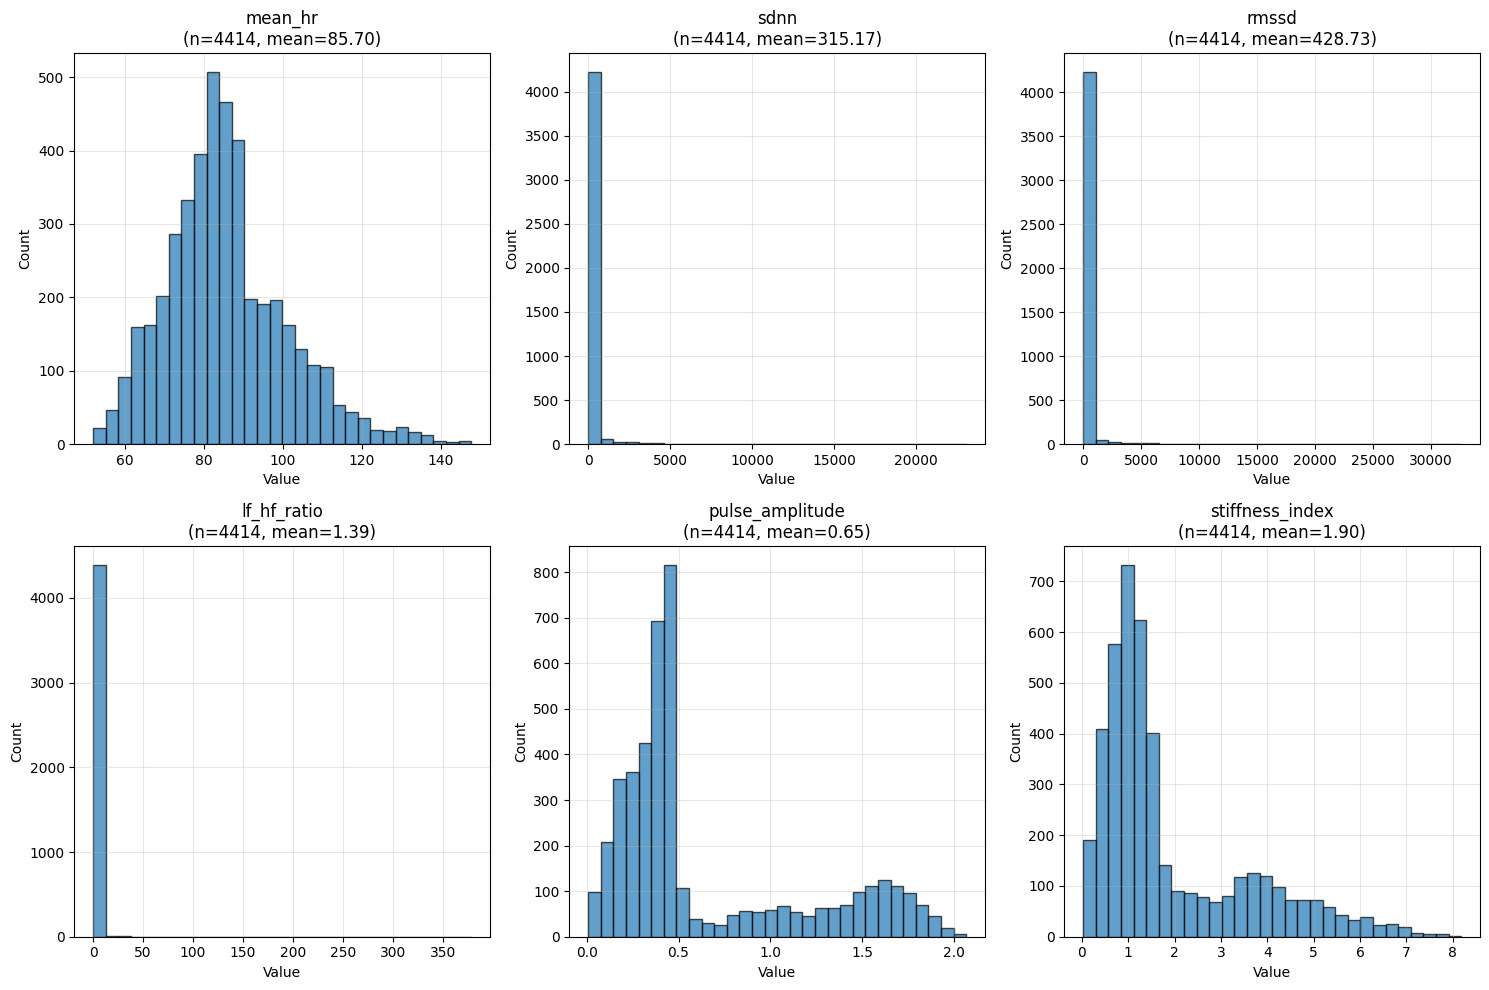

💾 Saved: data/features/feature_distributions.png


In [15]:
# Visualize feature distributions

print("\n" + "="*70)
print("FEATURE DISTRIBUTION VISUALIZATION")
print("="*70)

# Select key features to visualize
key_features = [
    'mean_hr', 'sdnn', 'rmssd', 'lf_hf_ratio',
    'pulse_amplitude', 'stiffness_index'
]

# Check which features are available
available_features = [f for f in key_features if f in feature_cols]

if len(available_features) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, feat in enumerate(available_features):
        if idx >= 6:
            break

        data = feature_data[feat].dropna()

        if len(data) > 0:
            axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{feat}\n(n={len(data)}, mean={data.mean():.2f})')
            axes[idx].set_xlabel('Value')
            axes[idx].set_ylabel('Count')
            axes[idx].grid(alpha=0.3)
        else:
            axes[idx].text(0.5, 0.5, 'No data', ha='center', va='center')
            axes[idx].set_title(f'{feat}\n(no data)')

    # Hide unused subplots
    for idx in range(len(available_features), 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('data/features/feature_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"💾 Saved: data/features/feature_distributions.png")

    # Log artifact
    tracker.log_artifact('data/features/feature_distributions.png')

else:
    print("⚠️  No key features available for visualization")

## Summary Report

In [16]:
# Generate comprehensive summary report

print("\n" + "="*70)
print("SPRINT 2 - FEATURE ENGINEERING SUMMARY")
print("="*70)

print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n📊 INPUT DATA:")
print(f"   Segments from Sprint 1: {len(signals)}")
print(f"   Unique subjects: {metadata['subject_id'].nunique()}")
print(f"   Mean SQI: {metadata['sqi_score'].mean():.3f}")

print(f"\n📊 FEATURE EXTRACTION:")
print(f"   Segments processed: {len(features_df)}")
print(f"   Success rate: {len(features_df)/len(signals)*100:.1f}%")
print(f"   Features per segment: {len(feature_cols)}")
print(f"   Total feature values: {len(features_df) * len(feature_cols):,}")

print(f"\n📊 FEATURE BREAKDOWN:")
print(f"   HRV features (time/freq/nonlinear): 30")
print(f"   Morphology features: 6")
print(f"   Clinical context features: 6")
print(f"   Total: {len(feature_cols)} features")

print(f"\n📊 FEATURE QUALITY:")
completeness = (1 - feature_data.isnull().sum() / len(feature_data)) * 100
print(f"   Mean completeness: {completeness.mean():.1f}%")
print(f"   Features >90% complete: {sum(completeness > 90)}")
print(f"   Features <50% complete: {sum(completeness < 50)}")
print(f"   Constant features: {len(constant_features)}")

print(f"\n💾 OUTPUT FILES:")
print(f"   ✅ data/features/feature_matrix.parquet ({features_df.shape})")
print(f"   ✅ data/features/feature_names.csv")
print(f"   ✅ data/features/correlation_matrix.png")
print(f"   ✅ data/features/feature_distributions.png")

print(f"\n🎯 SPRINT 3 READINESS:")
complete_segments = sum(feature_data.isnull().sum(axis=1) == 0)
if complete_segments >= 1000:
    print(f"   ✅ EXCELLENT: {complete_segments} complete segments")
    print(f"   → Ready for model training")
elif complete_segments >= 500:
    print(f"   ✅ GOOD: {complete_segments} complete segments")
    print(f"   → Sufficient for baseline models")
else:
    print(f"   ⚠️  LIMITED: {complete_segments} complete segments")
    print(f"   → May need feature imputation or more data")

print(f"\n⚠️  IMPORTANT: Subject Imbalance")
subject_dist = features_df.groupby('subject_id').size()
print(f"   Subjects: {len(subject_dist)}")
print(f"   Max segments from one subject: {subject_dist.max()}")
print(f"   → MUST use subject-wise train/test split in Sprint 3")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Handle missing values (imputation or removal)")
print(f"   2. Feature scaling/normalization")
print(f"   3. Feature selection (remove constant/low-variance)")
print(f"   4. Train baseline models (XGBoost, Random Forest)")
print(f"   5. Implement subject-wise cross-validation")

print("\n" + "="*70)


SPRINT 2 - FEATURE ENGINEERING SUMMARY

📅 Timestamp: 2026-01-06 23:39:05

📊 INPUT DATA:
   Segments from Sprint 1: 4417
   Unique subjects: 130
   Mean SQI: 0.958

📊 FEATURE EXTRACTION:
   Segments processed: 4417
   Success rate: 100.0%
   Features per segment: 37
   Total feature values: 163,429

📊 FEATURE BREAKDOWN:
   HRV features (time/freq/nonlinear): 30
   Morphology features: 6
   Clinical context features: 6
   Total: 37 features

📊 FEATURE QUALITY:
   Mean completeness: 99.9%
   Features >90% complete: 37
   Features <50% complete: 0
   Constant features: 0

💾 OUTPUT FILES:
   ✅ data/features/feature_matrix.parquet ((4417, 46))
   ✅ data/features/feature_names.csv
   ✅ data/features/correlation_matrix.png
   ✅ data/features/feature_distributions.png

🎯 SPRINT 3 READINESS:
   ✅ EXCELLENT: 4413 complete segments
   → Ready for model training

⚠️  IMPORTANT: Subject Imbalance
   Subjects: 13
   Max segments from one subject: 24
   → MUST use subject-wise train/test split in Spr

## End MLflow Run

In [17]:
# Finalize experiment tracking

tracker.end_run()

print("✅ Sprint 2 Complete - Feature Engineering")
print("   MLflow logs: logs/mlruns/")
print("\n📋 Deliverables:")
print("   ✓ Feature matrix ready")
print("   ✓ Quality analyzed")
print("   ✓ Visualizations generated")
print("\n→ Ready for Sprint 3: Model Training")

✅ Sprint 2 Complete - Feature Engineering
   MLflow logs: logs/mlruns/

📋 Deliverables:
   ✓ Feature matrix ready
   ✓ Quality analyzed
   ✓ Visualizations generated

→ Ready for Sprint 3: Model Training


In [21]:
# Run this to investigate
features_df = pd.read_parquet('data/features/feature_matrix.parquet')

print("Subject distribution:")
subject_dist = features_df['subject_id'].value_counts()
print(subject_dist)
print(f"\nTotal unique subjects: {len(subject_dist)}")
print(f"Total segments: {len(features_df)}")

Subject distribution:
subject_id
p001855    24
p001978     7
p001949     3
p000878     3
p000052     3
p001049     2
p000948     2
p000818     2
p001900     2
p001170     1
p001257     1
p001038     1
p001158     1
Name: count, dtype: int64

Total unique subjects: 13
Total segments: 4417
